#### Set up and test the processing of the openMRG data with pycomlink

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycomlink as pycml
import tqdm
import xarray as xr
import pycomlink.processing.wet_dry.cnn as cnn

2023-06-27 09:28:49.205685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 09:28:57.260155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from dask.delayed import delayed

# ivyshort - most resources if available
cluster = SLURMCluster(
    # Dask-worker specific keywords
    cores=40,             # Number of cores per job
    memory='60GB',       # Amount of memory per job
    processes=20,          # Number of Python processes to cut up each job
    local_directory='/pd/data/CML/data/tmp/max_dask_related/dask_tmp',  # Location to put temporary data if necessary
    queue='ivyshort',
    account='cml_proc',
    walltime='08:00:00'
)
client = Client(cluster)
cluster.scale(60)

In [4]:
client

<Client: 'tcp://172.27.80.110:45091' processes=60 threads=120, memory=167.40 GiB>

In [27]:
client.close()
cluster.close()

In [5]:
modelh5_fn = str(cnn.get_model_file_path() + "/model_2020.002.180m.h5")
modeljson_fn = str(cnn.get_model_file_path() + "/model_2020.002.180m.json")
# load json and create model
json_file = open(modeljson_fn, "r")
loaded_model_json = json_file.read()
json_file.close()
model = cnn.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(modelh5_fn)
model.compile()

In [6]:
# load json and create model
json_file = open(modeljson_fn, "r")
loaded_model_json = json_file.read()
json_file.close()
model = cnn.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(modelh5_fn)
model.compile()

In [57]:
cml = ds_cml_proc.isel(sublink=1)

In [58]:
cml["trsl"] = cml.tsl - cml.rsl

In [60]:
if (np.isnan(cml.trsl).sum())==(len(cml.trsl)):
     cml['R']=cml.trsl

In [ ]:
for cmlids in tqdm.tqdm(ds_cml_proc.sublink):
    cml = ds_cml_proc.sel(sublink=cmlids)
    if cml.tsl.sum() == 0:
        print(cml)

In [101]:
@dask.delayed
def pycml_proc(cml):
    
    cml = cml.copy()
    
    cml["trsl"] = cml.tsl - cml.rsl
    if (np.isnan(cml.trsl).sum())==(len(cml.trsl)):
        cml['R']=cml.trsl
        return cml
    if (cml.trsl.sum())==0:
        cml['R']=cml.trsl
        return cml
    
    else:
        cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')   
        use="cnn"  ### type cnn q80 or nearby

        # cnn wet dry
        if use == 'cnn':
            trsl_1min_first = pd.Series(cml.trsl.values[::6], index=cml.time.values[::6])
            classified = cnn.cnn_wet_dry(trsl_channel_1=trsl_1min_first, trsl_channel_2=trsl_1min_first, batch_size=100,  verbose=0)
            classified = pd.Series(classified,cml.time.values[::6]).resample("10s").ffill().reindex(cml.time.values)
            cml["wet"] = xr.full_like(cml.trsl, np.nan)
            cml["wet"].loc[:] = classified.values > 0.82

        if use == 'q80':
            trsl_1min_first = pd.Series(cml.trsl.values[::6], index=cml.time.values[::6])
            roll_std_dev_first = trsl_1min_first.rolling('60min', center=True).std() 
            threshold = 1.12*np.nanquantile(roll_std_dev_first.values,q=0.8)
            roll_std_dev = pd.Series(cml.trsl.values, index=cml.time.values).rolling('60min', center=True).std()
            cml["wet"] = xr.full_like(cml.trsl, np.nan)
            cml['wet'].loc[:] = (roll_std_dev>threshold).ffill().reindex(cml.time.values)

        if use == 'nerrby':
            cml['wet'] = np.nan


        cml['baseline'] = pycml.processing.baseline.baseline_constant(
            trsl=cml.trsl, 
            wet=cml.wet, 
            n_average_last_dry=5,
        )
        cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
            rsl=cml.trsl, 
            baseline=cml.baseline, 
            wet=cml.wet, 
            waa_max=2.2, 
            delta_t=1, 
            tau=15,
        )
        cml['A'] = cml.trsl - cml.baseline - cml.waa


        # Note that we set A < 0 to 0 here, but it is not strictly required for 
        # the next step, because calc_R_from_A sets all rainfall rates below 
        # a certain threshold (default is 0.1) to 0. Some people might want to
        # keep A as it is to check later if there were negative numbers.
        cml['A'].values[cml.A < 0] = 0
        if cml.polarization == 'Vertical':
            cml['polarization'] = 'v'
        if cml.polarization == 'Horizontal':
            cml['polarization'] = 'h'

        cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
            A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency, pol=cml.polarization
       )
        cml=cml.drop(['wet','baseline','waa','A',])
        return cml

In [2]:
ds_cml_proc = xr.open_dataset('cml/formatted_cml_2015_08.nc')

In [6]:
ds_cml_proc.sel(sublink=201).load()

<xarray.Dataset>
Dimensions:           (time: 267840)
Coordinates:
  * time              (time) datetime64[ns] 2015-08-01 ... 2015-08-31T23:59:50
    sublink           int32 201
    site_a_latitude   float64 57.71
    site_a_longitude  float64 12.01
    site_b_latitude   float64 57.73
    site_b_longitude  float64 12.04
    frequency         float64 33.26
    polarization      <U8 'Vertical'
    length            float64 2.792
Data variables:
    tsl               (time) float32 12.0 12.0 12.0 12.0 ... 12.0 12.0 12.0 12.0
    rsl               (time) float32 -47.0 -47.0 -47.0 ... -50.7 -50.4 -50.7
Attributes:
    title:    OpenMRG-CML
    version:  1.1
    source:   Swedish Meteorological and Hydrological Institute (SMHI), Hydro...
    contact:  hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:  https://creativecommons.org/licenses/by-sa/4.0
    doi:      https://doi.org/10.5281/zenodo.6673750
    comment:  Created by Jafet Andersson and Victor Naslund, SMHI. Time is in...

In [103]:
results = []
for cmlids in tqdm.tqdm(ds_cml_proc.sublink):
    cml = ds_cml_proc.sel(sublink=cmlids)
    cml = pycml_proc(cml)
    results.append(cml)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 728/728 [00:02<00:00, 340.41it/s]


In [104]:
print("processing month")
result = dask.compute(*results)

processing month


In [105]:
cml_proc = xr.concat(result, dim="cml_id")

In [106]:
cml_proc.to_netcdf('cml_cnn_intp_rain_openMRG_2015_08.nc')

In [14]:
cml_proc_old = xr.open_dataset("cml_q80_rain_openMRG_2015_06.nc")

In [163]:
%matplotlib inline

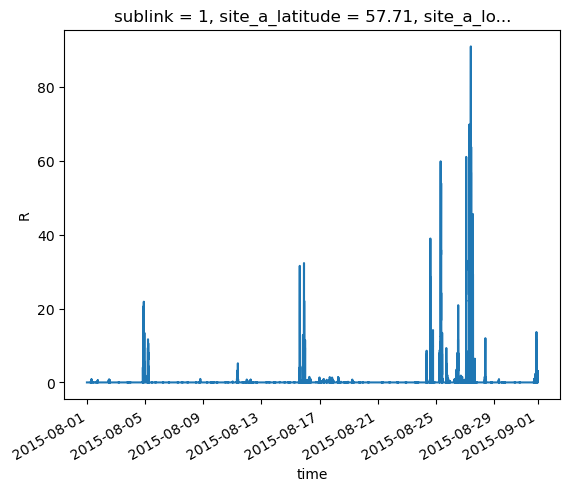

In [164]:
cml_proc.R.isel(cml_id=0).plot()

In [16]:
cml = ds_cml_proc.isel(sublink=0)

In [19]:
cml['trsl'] = cml.tsl - cml.rsl

In [24]:
trsl_1min_first = pd.Series(cml.trsl.values[::6], index=cml.time.values[::6])
classified = cnn.cnn_wet_dry(trsl_channel_1=trsl_1min_first, trsl_channel_2=trsl_1min_first, batch_size=100,  verbose=0)
classified = pd.Series(classified,cml.time.values[::6]).resample("10s").ffill().reindex(cml.time.values)
cml["wet"] = xr.full_like(cml.trsl, np.nan)
cml["wet"].loc[:] = classified.values > 0.82

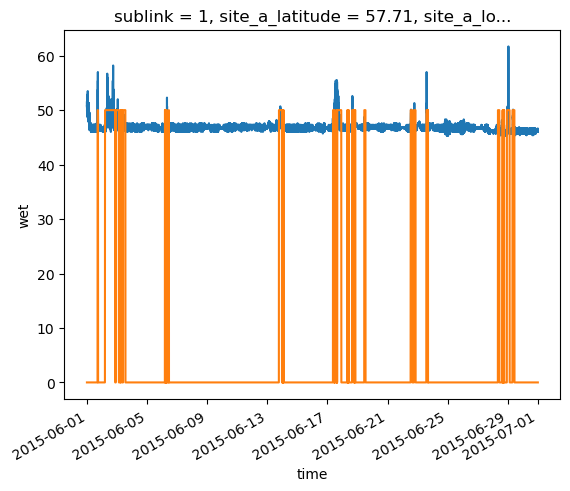

In [26]:
cml.trsl.plot()
(cml.wet*50).plot()

In [162]:
cml["trsl"] = cml.tsl - cml.rsl
trsl_1min_first = pd.Series(cml.trsl.values[::6], index=cml.time.values[::6])
roll_std_dev = trsl_1min_first.rolling('60min', center=True).std() 
threshold = 1.12*np.nanquantile(roll_std_dev.values,q=0.8)

In [160]:
%matplotlib widget

<AxesSubplot: >

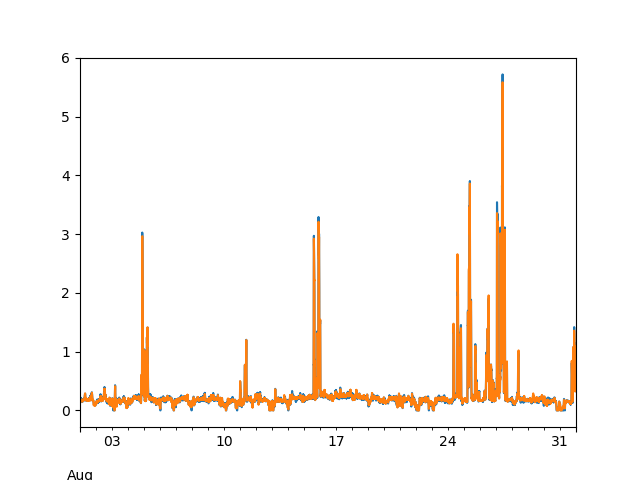

In [152]:
roll_std_dev.plot()
pd.Series(cml.trsl.values, index=cml.time.values).rolling('60min', center=True).std().plot()

In [ ]:
cml["wet"] = xr.full_like(cml.trsl, np.nan)
cml['wet'].loc[:] = (roll_std_dev>threshold).ffill().reindex(cml.time.values)
    
    

In [ ]:
    
use="q80"  ### type cnn q80 or nearby

# cnn wet dry
if use == 'cnn':
    trsl_1min_first = pd.Series(cml.trsl.values[::6], index=cml.time.values[::6])
    classified = cnn.cnn_wet_dry(trsl_channel_1=trsl_1min_first, trsl_channel_2=trsl_1min_first, batch_size=100,  verbose=0)
    classified = pd.Series(classified,cml.time.values[::6]).resample("10s").ffill().reindex(cml.time.values)
    cml["wet"] = xr.full_like(cml.trsl, np.nan)
    cml["wet"].loc[:] = classified.values

if use == 'q80':
    trsl_1min_first = pd.Series(cml.trsl.values[::6], index=cml.time.values[::6])
    roll_std_dev = trsl_1min_first.rolling('60min', center=True).std() 
    threshold = 1.12*np.nanquantile(roll_std_dev.values,q=0.8)
    cml["wet"] = xr.full_like(cml.trsl, np.nan)
    cml['wet'].loc[:] = (roll_std_dev>threshold).ffill().reindex(cml.time.values)

if use == 'nerrby':
    cml['wet'] = np.nan


cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=cml.trsl, 
    wet=cml.wet, 
    n_average_last_dry=5,
)
cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)
cml['A'] = cml.trsl - cml.baseline - cml.waa


# Note that we set A < 0 to 0 here, but it is not strictly required for 
# the next step, because calc_R_from_A sets all rainfall rates below 
# a certain threshold (default is 0.1) to 0. Some people might want to
# keep A as it is to check later if there were negative numbers.
cml['A'].values[cml.A < 0] = 0
if cml.polarization == 'Vertical':
    cml['polarization'] = 'v'
if cml.polarization == 'Horizontal':
    cml['polarization'] = 'h'

cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency, pol=cml.polarization
)
cml=cml.drop(['wet','baseline','waa','A',])
return cml